# Handling Missing Data

The goal of this task was to create an in-depth EDA on the Titanic dataset provided.

The section presented in this Notebook is how I handled missing data for the columns *Age* and *Embarked* (Port of embarkation).

In [94]:
# Import modules
import pandas as pd
import numpy as np
from numpy.random import randint
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [95]:
# Load data from Titanic.csv
titanic_df = pd.read_csv('Titanic.csv')

## Data exploration

In [96]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Meaning of each variable:**

| Variable | Description |
|:---------|:------------| 
| Survived | Survival (0 = No; 1 = Yes) |  
| Pclass   | Passenger Class* |
| Name     | Name |
| Sex      | Sex |
| Age      | Age |
| SibSp    | Number of **Sib**lings/**Sp**ouse aboard |
| Parch    | Number of **Par**ents/**Ch**ildren aboard |
| Ticket   | Ticket Number |
| Fare     | Passenger Fare (in British pound) |
| Cabin    | Cabin |
| Embarked | Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton) |

\* Passenger Class (*Pclass*) is a proxy for socio-economic status (1st = Upper; 2nd = Middle; 3rd = Lower) 

Source: http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf

## Missing Data

In [97]:
# Visualise missing data
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Port of embarkation

Missing values for the port of embarkation (*Embarked*) are not significative (0.2%), as they represent only 2 out of 891 passengers.

In [98]:
# Visualise the missing values for the port of embarkation
display(titanic_df[titanic_df['Embarked'].isna()])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


As we can see, these two passengers did not embark with family or relatives (*SibSp* and *Parch*), so only external sources (not present in this dataset) could allow us to determine their actual port of embarkation.  

Therefore, these two passengers will be assigned to the port where the majority of passengers boarded (i.e. Southampton).

In [99]:
# Select the port where most passengers embarked
embarked = titanic_df.groupby(['Embarked']).size().sort_values(ascending=False)

# Visualise data (C = Cherbourg; Q = Queenstown; S = Southampton)
print(f'Known passengers for each port of embarkation: {embarked}\n')

# Replace missing values for "Embarked" with the busiest port of embarkation
embarked = embarked.index[0]  # Select "S" for Southampton
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(embarked)
print('Assigning "Southampton" to passengers without a port of embarkation.\n')

# Verify that "Southampton" has been assigned to the two passengers. 
embarked = titanic_df.groupby(['Embarked']).size().sort_values(ascending=False)
print('Verification: New total of passengers for each port of embarkation:',
      embarked)

Known passengers for each port of embarkation: Embarked
S    644
C    168
Q     77
dtype: int64

Assigning "Southampton" to passengers without a port of embarkation.

Verification: New total of passengers for each port of embarkation: Embarked
S    646
C    168
Q     77
dtype: int64


## Missing Age

The data type of the *Age* column is on "float", so we will start by rounding the values, so as to avoid having decimals for the age value. 

In [100]:
# Round values to avoid having decimal for the age value
titanic_df = titanic_df.round({'Age':0}) 

* Missing age does represent a significative amount of values (19.9%) and is an important information.  
    * 30 in 1st class
    * 11 in 2nd class
    * 136 in 3rd class

In [101]:
# Count passengers whose age is missing for each travel class
age_pclass = titanic_df[titanic_df['Age'].isna()]
age_pclass.groupby('Pclass').count()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Pclass,,,,,,,,,,,
1,30,30,30,30,0,30,30,30,30,16,30
2,11,11,11,11,0,11,11,11,11,1,11
3,136,136,136,136,0,136,136,136,136,2,136


Here is my methodology to populate the missing values for the *Age* variable:
* Calculate the proportion of passengers for six age categories:
    * Under 10 years old (children)
    * 10-17 years old
    * 18-30 years old
    * 31-40 years old
    * 41-50 years old
    * Over 50 years old  
    
    *Note: Based on the demographic of early 20th century, and the demographic of the Titanic passengers, the "older" generation was actually those over 50, with very few passengers over 65 or 70 years old.*  
        
* Subdivide these categories based on gender (male / female) and travel class, in order to have a more accurate estimation.
* Then, based on this distribution, fill the missing values with random values **within** the respective age ranges.

In [102]:
# See columns index numbers
display(titanic_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

### Title "Master"

We need to handle a special modification for the title "Master" (young boys), otherwise there would be a discrepancy if the title "Master" was to be associated with an adult.

Boxplot showing the distribution of title "Master":

<Axes: >

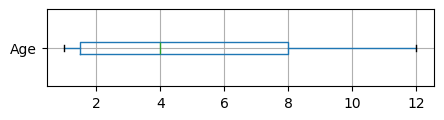

In [103]:
# Check the minimum and maximum age of passengers with the title "Master" 
master_age = titanic_df[titanic_df['Name'].str.contains('Master') & titanic_df['Age']]
master_age.boxplot(column=['Age'], figsize=(5,1), vert=False)

Most passengers with the title "Master" were aged 2-8 years old, with the oldest being 12 years old.  

Therefore, we will generate random ages between 2-8 years old to fill the missing *Age* values for "Master". 

In [104]:
# Select passengers with title "Master" and unknown "Age"
ag_master_condition = titanic_df[titanic_df['Name'].str.contains('Master') & titanic_df['Age'].isna()]
ag_master_condition = ag_master_condition.index.tolist()

# Number of entries
ag_master_len = len(ag_master_condition)

# Generate "Age" randomly (values between 2-8)
ag_master_rand = randint(2, 8, size=ag_master_len).tolist()

# Create dictionary
ag_master_dict = dict(zip(ag_master_condition, ag_master_rand))

# Update Dataframe
titanic_df.update({'Age': ag_master_dict})

In [105]:
# Verify that age is correctly replaced for "Master"
print(f'Conditions (index) => {ag_master_condition}')  # List with indexes
print(f'Random ages => {ag_master_rand}')  # Random ages generated (2-8 yrs old)
print(f'Dictionary => {ag_master_dict}')  # Assigning ages to passengers
# Check for example for index 65, if age is correctly filled:
print('\nVerification for PassengerId #65, "Master Gerios Moubarek":')
print(f'Passenger index 65 (Id 66):\n{titanic_df.loc[65,:]}')

Conditions (index) => [65, 159, 176, 709]
Random ages => [7, 3, 7, 3]
Dictionary => {65: 7, 159: 3, 176: 7, 709: 3}

Verification for PassengerId #65, "Master Gerios Moubarek":
Passenger index 65 (Id 66):
PassengerId                          66
Survived                              1
Pclass                                3
Name           Moubarek, Master. Gerios
Sex                                male
Age                                 7.0
SibSp                                 1
Parch                                 1
Ticket                             2661
Fare                            15.2458
Cabin                               NaN
Embarked                              C
Name: 65, dtype: object


Now that the title "Master" situation has been resolved, we can start filling missing ages for other passengers.

Frist, we will add a column "AgeGroup" to the dataframe, in order to split the passengers into six age categories:
* Under 10 years old
* 10 to 17 years old
* 18 to 30 years old
* 31 to 40 years old
* 41 to 50 years old
* over 50 years old

In [106]:
# Function to add/update "AgeGroup" columns
def age_group_column(): 
    # Age groups conditions
    ag_conditions = [titanic_df['Age'] < 10,
                    titanic_df['Age'].between(10, 17),
                    titanic_df['Age'].between(18, 30),
                    titanic_df['Age'].between(31, 40),
                    titanic_df['Age'].between(41, 50),
                    titanic_df['Age'] > 50]

    ag_values = ['under10', '10to17', '18to30', '31to40', '41to50', 'over50']

    # Add column "AgeGroup"
    titanic_df['AgeGroup'] = np.select(ag_conditions, ag_values)

# Add column "AgeGroup"
age_group_column()

# Total number of passengers
total_passengers = titanic_df.shape[0]

In [107]:
# Visualise distribution of passengers by age group (0 = missing age)
print('Distribution of passengers by age group.')
print('AgeGroup 0 = missing age\n')
age_groups = titanic_df.groupby(['Pclass', 'Sex', 'AgeGroup']).size()
print(age_groups)

Distribution of passengers by age group.
AgeGroup 0 = missing age

Pclass  Sex     AgeGroup
1       female  0             9
                10to17        7
                18to30       27
                31to40       24
                41to50       13
                over50       13
                under10       1
        male    0            21
                10to17        2
                18to30       22
                31to40       25
                41to50       24
                over50       26
                under10       2
2       female  0             2
                10to17        4
                18to30       32
                31to40       17
                41to50       10
                over50        3
                under10       8
        male    0             9
                10to17        2
                18to30       41
                31to40       26
                41to50        9
                over50       12
                under10       9
3       fema

In [108]:
# Function Fill missing values
def fill_missing_age(pclass, sex):
    ''' 
    This function uses the two arguments, "pclass" (passenger class), 
    and "sex" to select a specific group of passengers.
    Then, it  calculates the percentage of each age category within this group.
    Finally, it generates random ages within each age category in order to
    fill the missing values, in correlation with the age distribution of
    passengers with known age within this group. 
    '''

    # Run the function if there are still missing values for column "Age",
    # otherwise, exit the function
    if titanic_df['Age'].isnull().sum() > 0:
        # Select passengers for specific group (based on Pclass and Sex) 
        filter = np.where((titanic_df['Pclass'] == pclass) & 
                        (titanic_df['Sex'] == sex))
        values = titanic_df.loc[filter]
        total = values['PassengerId'].count()  # Total passengers 
        subtotal = values.groupby(['AgeGroup']).size()  # Passengers by age group
        age_missing = subtotal.iloc[0]  # Passengers with missing age
        age_known = total - age_missing  # Passengers with known age
        
        # Calculate percentage of each age category
        a_10to17 = subtotal.iloc[1] / age_known
        a_18to30 = subtotal.iloc[2] / age_known
        a_31to40 = subtotal.iloc[3] / age_known
        a_41to50 = subtotal.iloc[4] / age_known
        a_over50 = subtotal.iloc[5] / age_known
        a_under10 = subtotal.iloc[6] / age_known

        # Determine the distribution of passengers with missing Age
        m_10to17 = round(age_missing * a_10to17)
        m_18to30 = round(age_missing * a_18to30)
        m_31to40 = round(age_missing * a_31to40)
        m_41to50 = round(age_missing * a_41to50)
        m_over50 = round(age_missing * a_over50)
        m_under10 = round(age_missing * a_under10)
        
        # Check if all missing values have been filled,
        # otherwise attribute the missing value to the "31 to 40" category
        # This problem can only appears for very low number of passengers
        # with missing age, so it would only affect 1 or 2 passenger names. 
        total_missing = m_10to17 + m_18to30 + m_31to40 + m_41to50 + m_over50 + m_under10
        check = age_missing - total_missing
        if check != 0:
            m_31to40 = m_31to40 + check

        # Lists of ID (index) for missing age
        condition = values[values['Age'].isna()]
        to_fill = condition.index.tolist()

        # Generate random ages
        random_ages = randint(10, 18, size=m_10to17).tolist()
        random_ages.extend(randint(18, 31, size=m_18to30).tolist())
        random_ages.extend(randint(31, 41, size=m_31to40).tolist())
        random_ages.extend(randint(41, 51, size=m_41to50).tolist())
        random_ages.extend(randint(51, 70, size=m_over50).tolist())
        random_ages.extend(randint(1, 10, size=m_under10).tolist())

        # Create dictionary
        fill_dict = dict(zip(to_fill, random_ages))

        # Update dataframe
        titanic_df.update({'Age': fill_dict})

        # Check if all missing values have been replaced
        if (pclass == 3) & (sex == 'male'):  # Last call of the function
            if titanic_df['Age'].isnull().sum() == 0:
                print('All missing values for column "Age" have now been filled.')
            else:
                print('Some values are still missing for column "Age".\nPlease run the function again.')

    else:
        # Display notification if all missing values for "Age" have been filled 
        if (pclass == 3) & (sex == 'male'):  # Last call of the function
            print('All missing values for column "Age" have now been filled.')


# Call the "fill_missing_age" function for each passenger group
# Arguments: "passenger class" and "sex" 
fill_missing_age(1, 'female')
fill_missing_age(2, 'female')
fill_missing_age(3, 'female')
fill_missing_age(1, 'male')
fill_missing_age(2, 'male')
fill_missing_age(3, 'male')

# Update column "AgeGroup"
age_group_column()

# titanic_df.sample(40)

All missing values for column "Age" have now been filled.


We can now check there are no more missing values for the column *Age* (i.e. absence of "AgeGroup 0")

In [109]:
# Double check there are no more missing values for "Age"
titanic_df.isnull().sum()

# Visualise distribution of passengers by age group (0 = missing age)
age_groups = titanic_df.groupby(['Pclass', 'Sex', 'AgeGroup']).size()
print(age_groups)

Pclass  Sex     AgeGroup
1       female  10to17        8
                18to30       30
                31to40       27
                41to50       14
                over50       14
                under10       1
        male    10to17        2
                18to30       27
                31to40       31
                41to50       29
                over50       31
                under10       2
2       female  10to17        4
                18to30       33
                31to40       18
                41to50       10
                over50        3
                under10       8
        male    10to17        2
                18to30       45
                31to40       28
                41to50       10
                over50       13
                under10      10
3       female  10to17       20
                18to30       64
                31to40       18
                41to50       11
                over50        1
                under10      30
        male   

# Data visualistion

The following plots show the survival rate based on the age of passengers. 

In [110]:
# Drop unused columns 
titanic_copy_df = titanic_df.drop(columns=['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'])

# Replace categorical variables by numerical values 
titanic_copy_df['AgeGroup'] = titanic_copy_df['AgeGroup'].map({'under10':0, '10to17':1, '18to30':2, '31to40':3, '41to50':4, 'over50':5})

#### **Plot based on the predefined Age Groups**

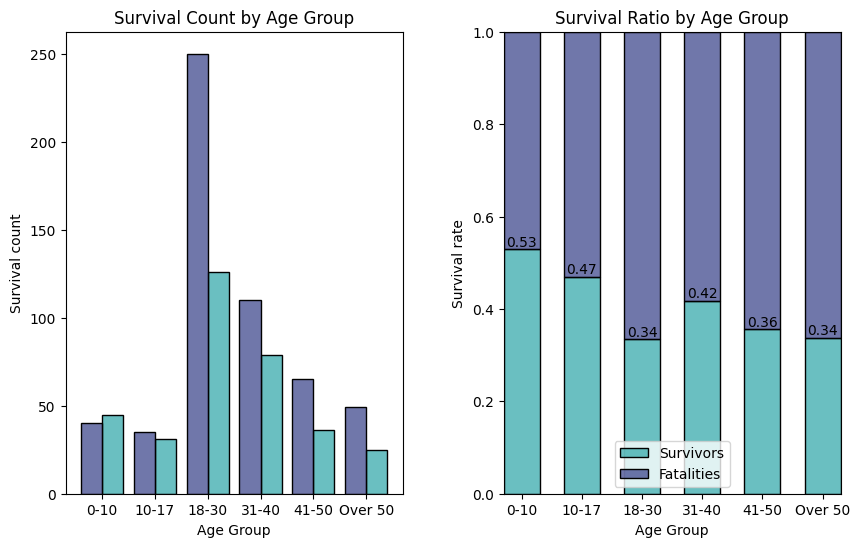

In [111]:
# Survival - based on Age Groups
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
plt.tight_layout

# Survival count
sns.histplot(data=titanic_copy_df, x='AgeGroup', hue='Survived', 
             multiple='dodge', palette='mako', discrete=True, shrink=0.8, 
             legend=False, ax=ax1)
ax1.set(title='Survival Count by Age Group')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Survival count')
ax1.set_xticks([0, 1, 2, 3, 4, 5])
ax1.set_xticklabels(['0-10', '10-17','18-30', '31-40', '41-50', 'Over 50'])

# Survival rate
sns.histplot(data=titanic_copy_df, x='AgeGroup', hue='Survived', 
             multiple='fill', stat='percent', palette='mako', 
             discrete=True, shrink=0.6, legend=False, ax=ax2)
ax2.set(title='Survival Ratio by Age Group')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Survival rate')
ax2.set_xticks([0, 1, 2, 3, 4, 5])
ax2.set_xticklabels(['0-10', '10-17','18-30', '31-40', '41-50', 'Over 50'])
ax2.bar_label(ax2.containers[0], fmt='%.2f')

plt.legend(labels=['Survivors', 'Fatalities'])
plt.subplots_adjust(wspace=0.3)
plt.show()

Even though the 18-30 group is the most represented, it also features one of the lowest survival rate (34%). 

Children under 10 years old have the highest survival rate, followed by the 10-17 group. 

The following plot will help us visualising more details **within** these groups. 

### **Plot  based on the exact age (increments of 3-4 years)**

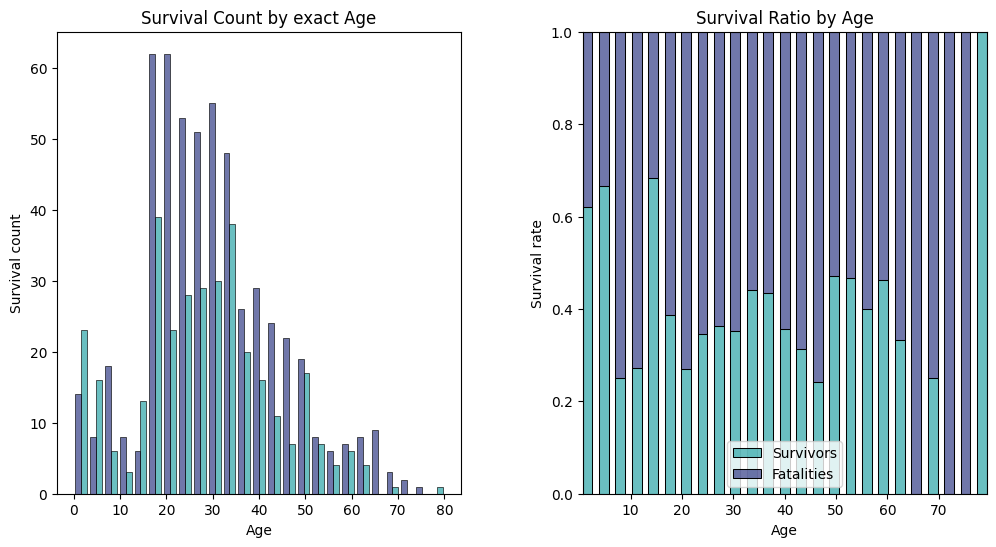

In [112]:
# Survival - based on exact Age (not Age Group)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plt.tight_layout

# Survival count
sns.histplot(data=titanic_copy_df, x='Age', hue='Survived', 
             multiple='dodge', palette='mako', shrink=0.8, bins=25,
             legend=False, ax=ax1)
ax1.set(title='Survival Count by exact Age')
ax1.set_xlabel('Age')
ax1.set_ylabel('Survival count')

# Survival rate
sns.histplot(data=titanic_copy_df, x='Age', hue='Survived', 
             multiple='fill', stat='percent', palette='mako', bins=25,
             shrink=0.6, legend=False, ax=ax2)
ax2.set(title='Survival Ratio by Age')
ax2.set_xlabel('Age')
ax2.set_ylabel('Survival rate')

plt.legend(labels=['Survivors', 'Fatalities'])
plt.subplots_adjust(wspace=0.3)
plt.show()

Overall, this plot matches the previous Age Group plot for passengers aged between 18 and 70 years old. 

There are three noteworthy differences: 

1. For the age group 0-10 years old, there is a high survival rate for children under 5, whilst children aged 5-10 years old have a similar survival rate than adult passengers (roughly between 35% and 40%).  

2. A similar observation can be made for the age group 10-17 years old, with a high survival rate (nearly 60%) for teenagers around 15 years old. But passengers aged 10-13 years old, and those aged 17-18 years old show a similar survival rate than adult passengers. 

3. The "Exact Age" plot shows a survival rate of 100% for passengers aged 80 years old. However, it is clearly an outlier, as shown by the "Survival Count" plot.  
    The query below confirms that *only one* passenger older than 75 years old was aboard the Titanic.   

In [113]:
# Display Age of oldest passengers.
titanic_df['Age'].sort_values(ascending=False).head()

630    80.0
851    74.0
96     71.0
493    71.0
116    70.0
Name: Age, dtype: float64